# LINEAR REGRESSION : ASSIGNMENT (BOOMBIKES DATASET)

## LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

## DATA READING & PREREQUISITES

### Data Preperation Functions

In [3]:
def read_data_file(path):
    df = pd.read_csv(path)
    df = df.drop(columns=["instant"])
    return df

def data_correction_and_validation(data, inplace=False):
    df = data if inplace else data.copy()
    df["dteday"] = pd.to_datetime(df["dteday"])
    df["season"] = df["season"].map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})
    df["yr"] = df["yr"].map({0:"2018", 1:"2019"})
    df["mnth"] = df["dteday"].apply(lambda x: x.strftime("%B"))
    df["holiday"] = df["holiday"].map({0:"No Holiday", 1:"Holiday"})
    df["weekday"] = df["weekday"].map({i:str(i) for i in range(7)})
    df['weekday'] = df["dteday"].apply(lambda x: x.strftime("%A"))
    df["workingday"] = df["workingday"].map({0:"Not Working", 1:"Working"})
    df["weathersit"] = df["weathersit"].map({1:"Clear+Cloudy", 2:"Mist+Cloudy", 3:"Light Rain+Snow", 4:"Heavy Rain+Snow"})
    df = df.sort_values("dteday", ascending=True)
    return df

### Data Analysis Function

In [4]:
def create_bargraph(x=None, y=None, data=None, hue=None, title=None, ax=None):
    plt.title(title)
    sns.barplot(x=x, y=y, data=data, hue=hue, ax=ax)
    return None

def create_distplot(x=None, y=None, data=None, hue=None, title=None, ax=None):
    plt.title(title)
    sns.distplot(x=x, y=y, data=data, hue=hue, ax=ax)
    return None

def create_histogram(x=None, y=None, data=None, hue=None, log=False, sqrt=False, ax=None):
    if log:
        sns.histplot(np.log(data[x]+0.1), ax=ax)
    else:
        sns.histplot(x=x, y=y, data=data, hue=hue, ax=ax)
    return None

def create_box_plot(x=None, y=None, data=None, hue=None, log=False, sqrt=False, ax=None):
    if log:
        sns.boxplot(np.log(data[x]+0.1),ax=ax)
    else:
        sns.boxplot(x=x, y=y, data=data, hue=hue, ax=ax)
    return None

def distribution_plot_for_categorical_features(data, perc=False, figsize=(10, 30)):
    df = data.select_dtypes(include="object")
    fig, ax = plt.subplots(len(df.columns), 1, figsize=figsize)
    for i, col in enumerate(df.columns):
        if perc:
            new_df = pd.DataFrame(df[col].value_counts(normalize=True)).reset_index()
        else:
            new_df = pd.DataFrame(df[col].value_counts()).reset_index()
        ax[i].barh(new_df["index"], new_df[col])
        ax[i].invert_yaxis()
        ax[i].set_title('Value Distribution for '+col, loc ='left', )
    plt.show()
    return None

def distribution_plot_for_numerical_features(data, log=False, figsize=(10, 30)):
    num_cols = data.select_dtypes(include="number").columns
    fig, ax = plt.subplots(len(num_cols), 2, figsize=figsize)
    for i in range(len(num_cols)):
        create_box_plot(num_cols[i], data=data, ax=ax[i][0], log=log)
        create_histogram(num_cols[i], data=data, ax=ax[i][1], log=log)
    return None

def create_heatmap(data, cmap="RdYlGn", figsize=(10, 10)):
    plt.figure(figsize=figsize)
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, cmap="RdYlGn", annot=True, vmin=-1, vmax=1, mask=mask)
    return None

def create_unique_numeric_and_object_pairs(num_cols, cat_cols):
    unique_list = [(num,cat) for num in num_cols for cat in cat_cols]
    return unique_list

def boxplots_for_numeric_and_object_features(data, numeric_filter=None, categorical_filter=None, hue=None, figsize=(10, 30)):
    num_cols = data.select_dtypes(include="number").columns
    cat_cols = data.select_dtypes(include="object").columns
    combinations = create_unique_numeric_and_object_pairs(num_cols, cat_cols)
    if numeric_filter:
        new_combinations = [x for x in combinations if x[0]==numeric_filter]
    if categorical_filter:
        new_combinations += [x for x in combinations if x[1]==categorical_filter]
    if numeric_filter==None and categorical_filter==None:
        new_combinations = combinations
    fig, ax = plt.subplots(len(new_combinations), 1, figsize=figsize)
    for i in range(len(new_combinations)):
        create_box_plot(new_combinations[i][1], new_combinations[i][0], data=data, ax=ax[i], hue=hue)
    return None

### Regression & Hypothesis Functions

In [18]:
def create_dummy_variables_for_all_categorical_features(data):
    num_df = data.select_dtypes(include="number")
    cat_df = data.select_dtypes(include="object")
    for col in cat_df.columns:
        dummy_df = pd.get_dummies(data[col], drop_first = True)
        num_df = pd.concat((num_df, dummy_df), axis=1)
    return num_df

def prepare_data_for_modeling(data, split_size=0.8, dep_var="cnt", minmaxscaling=False, standardscaling=False):
    df = data.copy()
    df = create_dummy_variables_for_all_categorical_features(df)
    np.random.seed(0)
    train, test = train_test_split(df, train_size=split_size, test_size=1-split_size, random_state=100)
    if minmaxscaling:
        scaler = MinMaxScaler()
        train[train.columns] = scaler.fit_transform(train[train.columns])
        test[train.columns] = scaler.transform(test[train.columns])
    if standardscaling:
        scaler = StandardScaler()
        train[train.columns] = scaler.fit_transform(train[train.columns])
        test[train.columns] = scaler.transform(test[train.columns])
    y_train = train.pop(dep_var)
    X_train = train
    y_test = test.pop(dep_var)
    X_test = test
    return X_train, X_test, y_train, y_test


def create_VIF_table(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif_data

def create_OLS_model(X, y, predict=False, res_analysis=False):
    lm = sm.OLS(y, X).fit()
    if predict:
        model_prediction(lm, X, y, res_analysis)
    return lm

def model_prediction(model, X, y, res_analysis=False):
    y_pred = model.predict(X)
    if res_analysis:
        res = y - y_pred
        plt.title("RESIDUAL ANALYSIS")
        sns.distplot(res)
    return None

def plot_predictions(y_test, y_pred):
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test, y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)
    plt.xlabel('y_test', fontsize=18)
    plt.ylabel('y_pred', fontsize=16)
    return None

def histogram_comparison_for_true_and_predicted_values(y_true, y_pred):
    plt.figure(figsize=(12,6))
    plt.title("TRUE VS PREDICTED DISTRIBUTION")
    sns.distplot(y_true, rug=True, hist=False, label="True")
    sns.distplot(y_pred, rug=True, hist=False, label="Predicted")

def model_evaluation(y_true, y_pred):
    eval_dict = dict()
    eval_dict["MSE"] = mean_squared_error(y_true, y_pred)
    eval_dict["MSE"] = mean_squared_error(y_true, y_pred)
    eval_dict["RMSE"] = mean_squared_error(y_true, y_pred, squared=False)
    eval_dict["MAE"] = mean_absolute_error(y_true, y_pred)
    eval_dict["R2"] = r2_score(y_true, y_pred)
    df = pd.DataFrame([eval_dict], index=["Scores"])
    pred_table = pd.DataFrame()
    pred_table["y_true"] = y_true
    pred_table["y_pred"] = y_pred
    return df.T, pred_table

def create_plots_for_comparison(y_true_1, y_pred_1, y_true_2, y_pred_2):
    plt.figure(figsize=(30, 30))
    plt.subplot(3,2,1)
    sns.scatterplot(y_true_1, y_pred_1)
    plt.xlabel("Predicted", {"fontsize": 18})
    plt.ylabel("True", {"fontsize": 18})
    plt.title("Q-Q PLOT (WITHOUT YEAR)", {"fontsize": 24})
    
    plt.subplot(3,2,3)
    sns.distplot(y_true_1, hist=False, rug=True, label="true")
    sns.distplot(y_pred_1, hist=False, rug=True, label="predicted")
    plt.legend(["true", "predicted"])
    plt.ylabel("Density", {"fontsize": 18})
    plt.title("TRUE VS PREDICTED (WITHOUT YEAR)", {"fontsize": 24})
    
    plt.subplot(3,2,5)
    sns.distplot(y_true_1-y_pred_1)
    plt.title("RESIDUAL ANALYSIS (WITHOUT YEAR)", {"fontsize": 24})
    
    plt.subplot(3,2,2)
    sns.scatterplot(y_true_2, y_pred_2)
    plt.xlabel("Predicted", {"fontsize": 18})
    plt.ylabel("True", {"fontsize": 18})
    plt.title("Q-Q PLOT (WITH YEAR)", {"fontsize": 24})
    
    plt.subplot(3,2,4)
    sns.distplot(y_true_2, hist=False, rug=True, label="true")
    sns.distplot(y_pred_2, hist=False, rug=True, label="predicted")
    plt.legend(["true", "predicted"])
    plt.legend(["true", "predicted"])
    plt.title("TRUE VS PREDICTED (WITH YEAR)", {"fontsize": 24})
    
    plt.subplot(3,2,6)
    sns.distplot(y_true_2-y_pred_2)
    plt.legend(["true", "predicted"])
    plt.title("RESIDUAL ANALYSIS (WITH YEAR)", {"fontsize": 24})
    return None

### Reading BoomBike Dataset

In [6]:
# reading bike sharing data
raw_data = read_data_file("./day.csv")

# check if the data was read correctly
display(raw_data.head())

# display info for bike sharing data
display(raw_data.info())

# column wise detailed information
display(raw_data.describe(include="all").T)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 85.7+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dteday,730,730,31-01-2019,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,730.0,NaN,NaN,NaN,2.49863,1.110184,1.0,2.0,3.0,3.0,4.0
yr,730.0,NaN,NaN,NaN,0.5,0.500343,0.0,0.0,0.5,1.0,1.0
mnth,730.0,NaN,NaN,NaN,6.526027,3.450215,1.0,4.0,7.0,10.0,12.0
holiday,730.0,NaN,NaN,NaN,0.028767,0.167266,0.0,0.0,0.0,0.0,1.0
weekday,730.0,NaN,NaN,NaN,2.99589,2.000339,0.0,1.0,3.0,5.0,6.0
workingday,730.0,NaN,NaN,NaN,0.690411,0.462641,0.0,0.0,1.0,1.0,1.0
weathersit,730.0,NaN,NaN,NaN,1.394521,0.544807,1.0,1.0,1.0,2.0,3.0
temp,730.0,NaN,NaN,NaN,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,NaN,NaN,NaN,23.726322,8.150308,3.95348,16.889713,24.368225,30.445775,42.0448


### Updating Features Datatypes

There are **730 records** for the period of 2 years and **16 columns** at the beginning but **dropped instant column** as it's just a row number.<br>
It appears that some of the **features belong to categorical** feature type by are represented as numeric data type. Before moving forward on exploratory data analysis part let's **convert those datatypes** to their proper form.

In [7]:
# prior corrections on the dataset for further analysis
rect_data = data_correction_and_validation(raw_data)

# check if the data was read correctly
display(rect_data.head())

# display info for bike sharing data
display(rect_data.info())

# column wise detailed information
display(rect_data.describe(include="all").T)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2018-01-01,spring,2018,January,No Holiday,Monday,Working,Mist+Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
31,2018-01-02,spring,2018,January,No Holiday,Tuesday,Working,Mist+Cloudy,7.879134,11.72650,82.9565,3.565271,47,1313,1360
59,2018-01-03,spring,2018,January,No Holiday,Wednesday,Working,Clear+Cloudy,10.933347,13.19395,53.5000,14.500475,137,1714,1851
90,2018-01-04,summer,2018,January,No Holiday,Thursday,Not Working,Mist+Cloudy,12.300000,14.17270,68.6250,17.333436,307,1920,2227
120,2018-01-05,summer,2018,January,No Holiday,Friday,Working,Mist+Cloudy,18.518347,22.41020,76.2083,7.125718,1138,2213,3351


<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    object        
 2   yr          730 non-null    object        
 3   mnth        730 non-null    object        
 4   holiday     730 non-null    object        
 5   weekday     730 non-null    object        
 6   workingday  730 non-null    object        
 7   weathersit  730 non-null    object        
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  casual      730 non-null    int64         
 13  registered  730 non-null    int64         
 14  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(7)
memory usage: 91.2+ 

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
dteday,730,730,2018-12-21 00:00:00,1,2018-01-01,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,730,4,fall,188,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr,730,2,2018,365,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mnth,730,12,July,62,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,730,2,No Holiday,709,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,730,7,Tuesday,105,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,730,2,Working,504,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weathersit,730,3,Clear+Cloudy,463,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,730.0,NaN,NaN,NaN,NaT,NaT,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,NaN,NaN,NaN,NaT,NaT,23.726322,8.150308,3.95348,16.889713,24.368225,30.445775,42.0448


The **data doesn't have any null values** so no imputation or removal is required and all the features are **converted to proper datatypes**.

## EXPLORATORY DATA ANALYSIS

For exploratory data analysis, let's look into **univariate**, **bivariate** and **multivariate** analsis for better understanding of the distribution and contribution of the features.

### Univariate Analysis

Looking into the distribution of all the categorical features

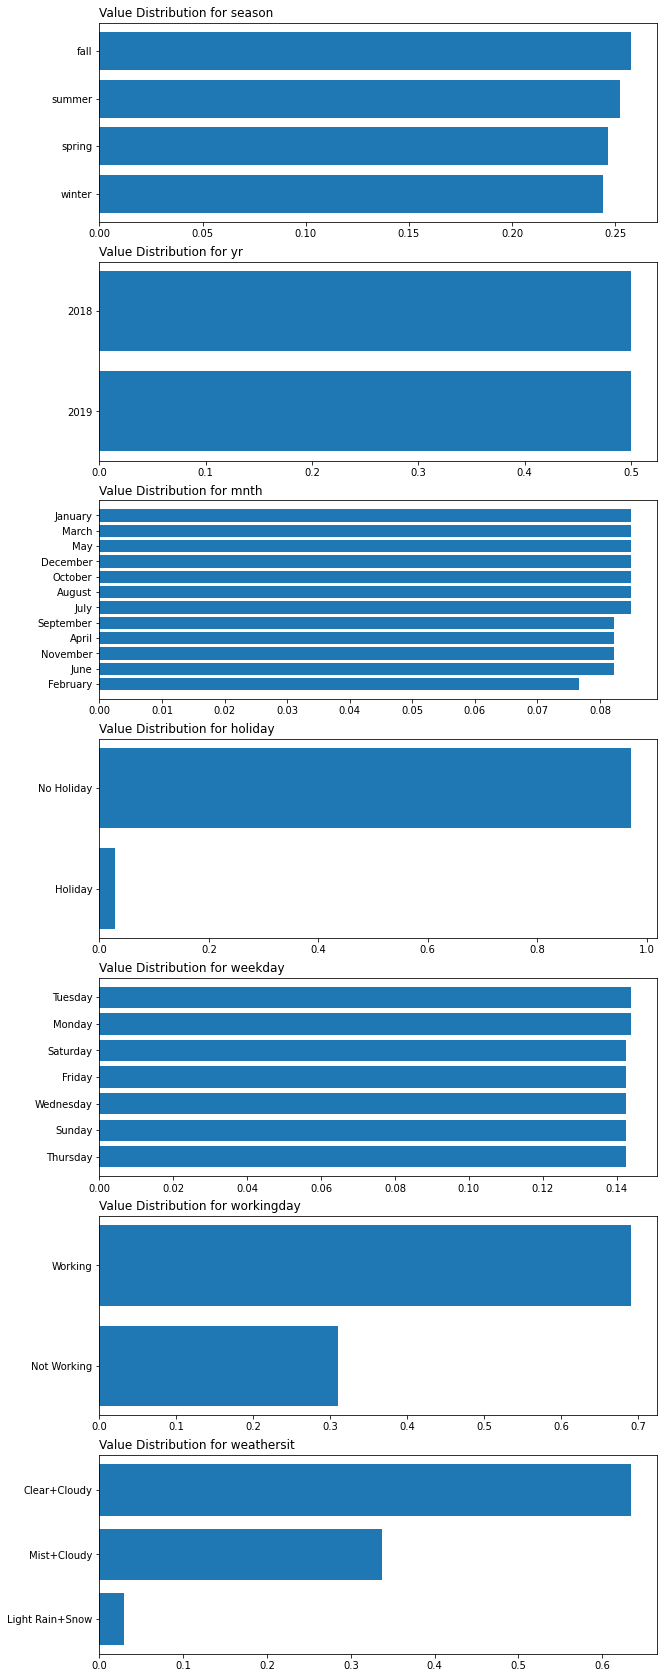

In [6]:
distribution_plot_for_categorical_features(rect_data, perc=True)

- 1. The **mnth** and **season** feature will be **positively correlated** as they represents the same information just difference in breakdown. 
- 2. The **holiday** and **workingday** feature will be **positively correlated** as they are quite similar in interpretaion.
- 3. When there is a **workingday** and when there is not a **holiday** holds significantly **large contribtion** to the dataset by approximately **69%** and **98%** respectively.
- 4. Contribution of **weathersit** is large of **type 1** which is **Clear, Few clouds, Partly cloudy or Partly cloudy**.

Now looking into the distribution of all the numerical features without any data transformation

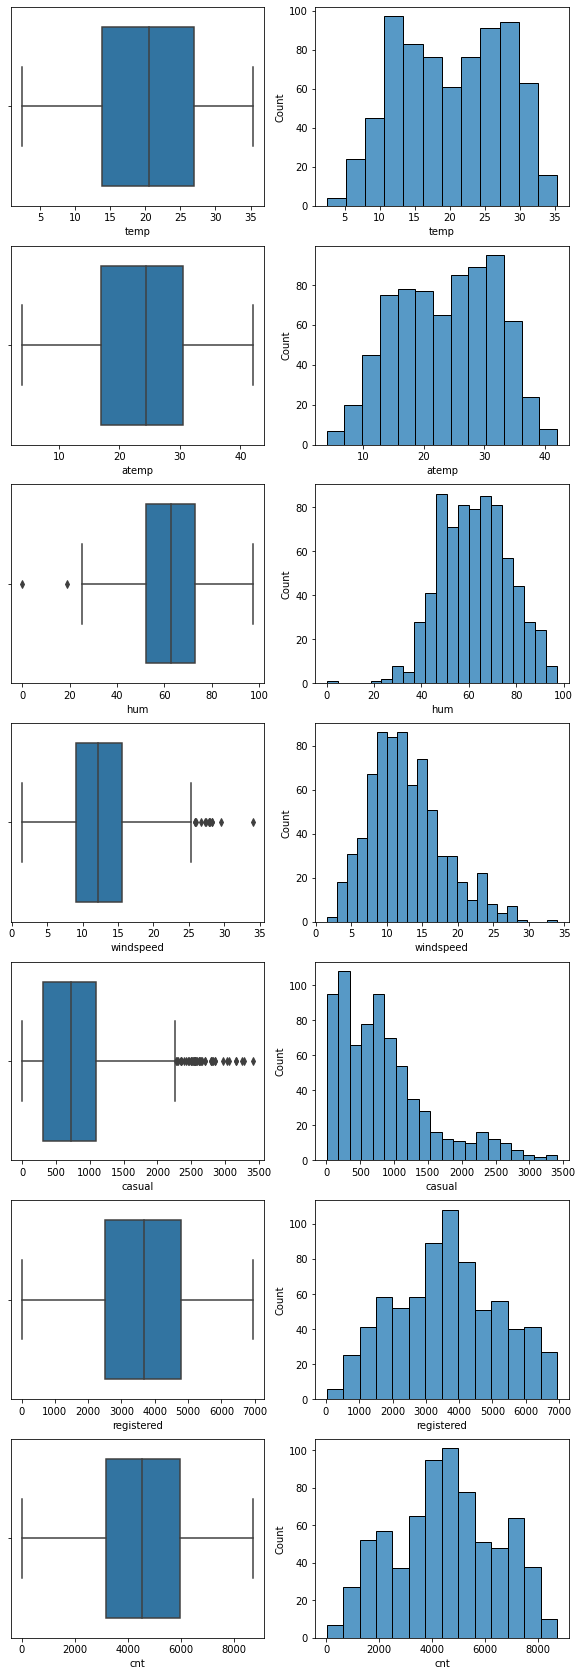

In [7]:
distribution_plot_for_numerical_features(rect_data)

- 1. **hum** which is humidity, **windspeed** and **casual** which is count of casual users **have outliers** with them.
- 2. All other features are defined within quantile range.

Looking into the distribution of all the numerical features with logarithmic transformation, to check if the outliers can be resolved as it makes numeric highly sensitive to the scale.

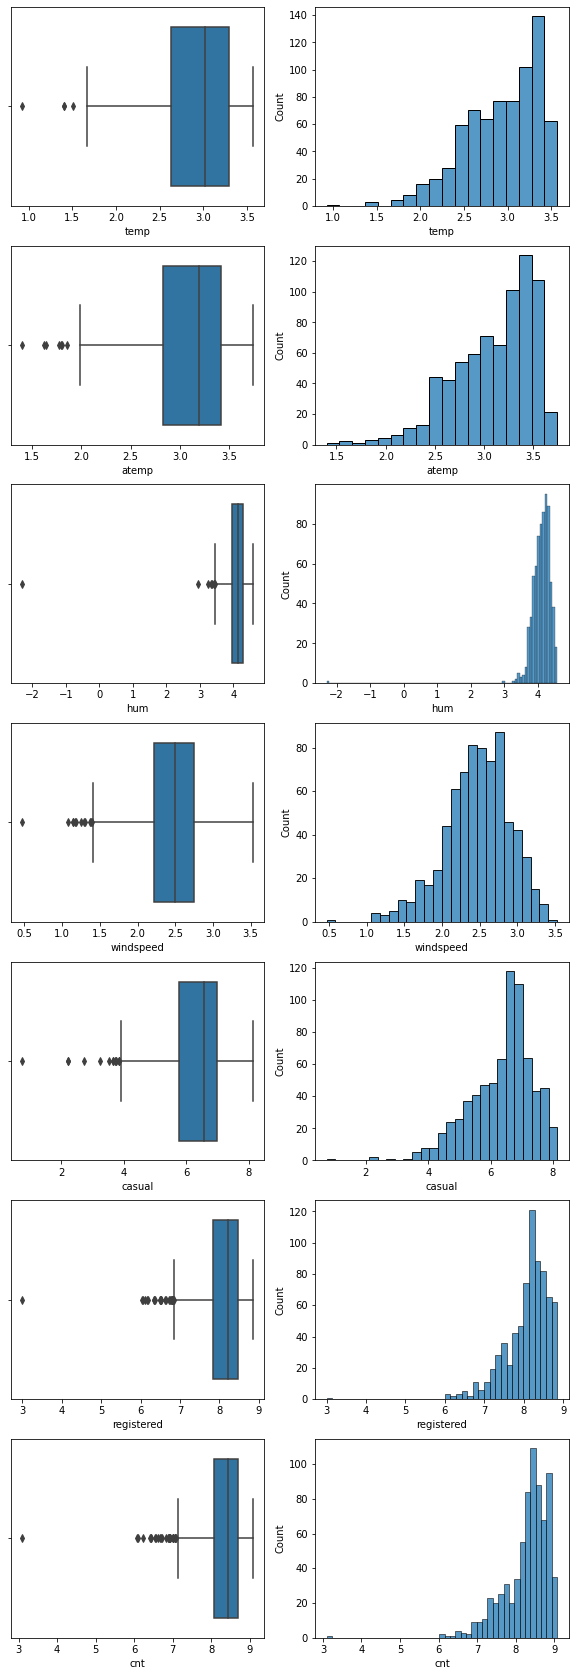

In [8]:
distribution_plot_for_numerical_features(rect_data, log=True)

- 1. Clearly **log transformation** will **not a good option** to treat outliers.
- 2. We can appy **binning** to **treat outliers**.

### Bivariate Analysis

#### NUMERICAL VS NUMERICAL

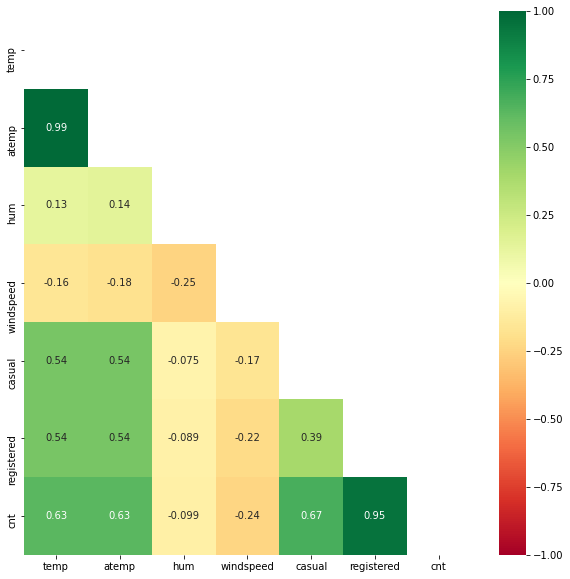

In [9]:
create_heatmap(rect_data)

- 1. User counts groups **(casual, registerd and cnt)** are **highly correlated**.
- 2. **temp** and **atemp** are moderatly **correlated** with each other along with **users counts groups**.

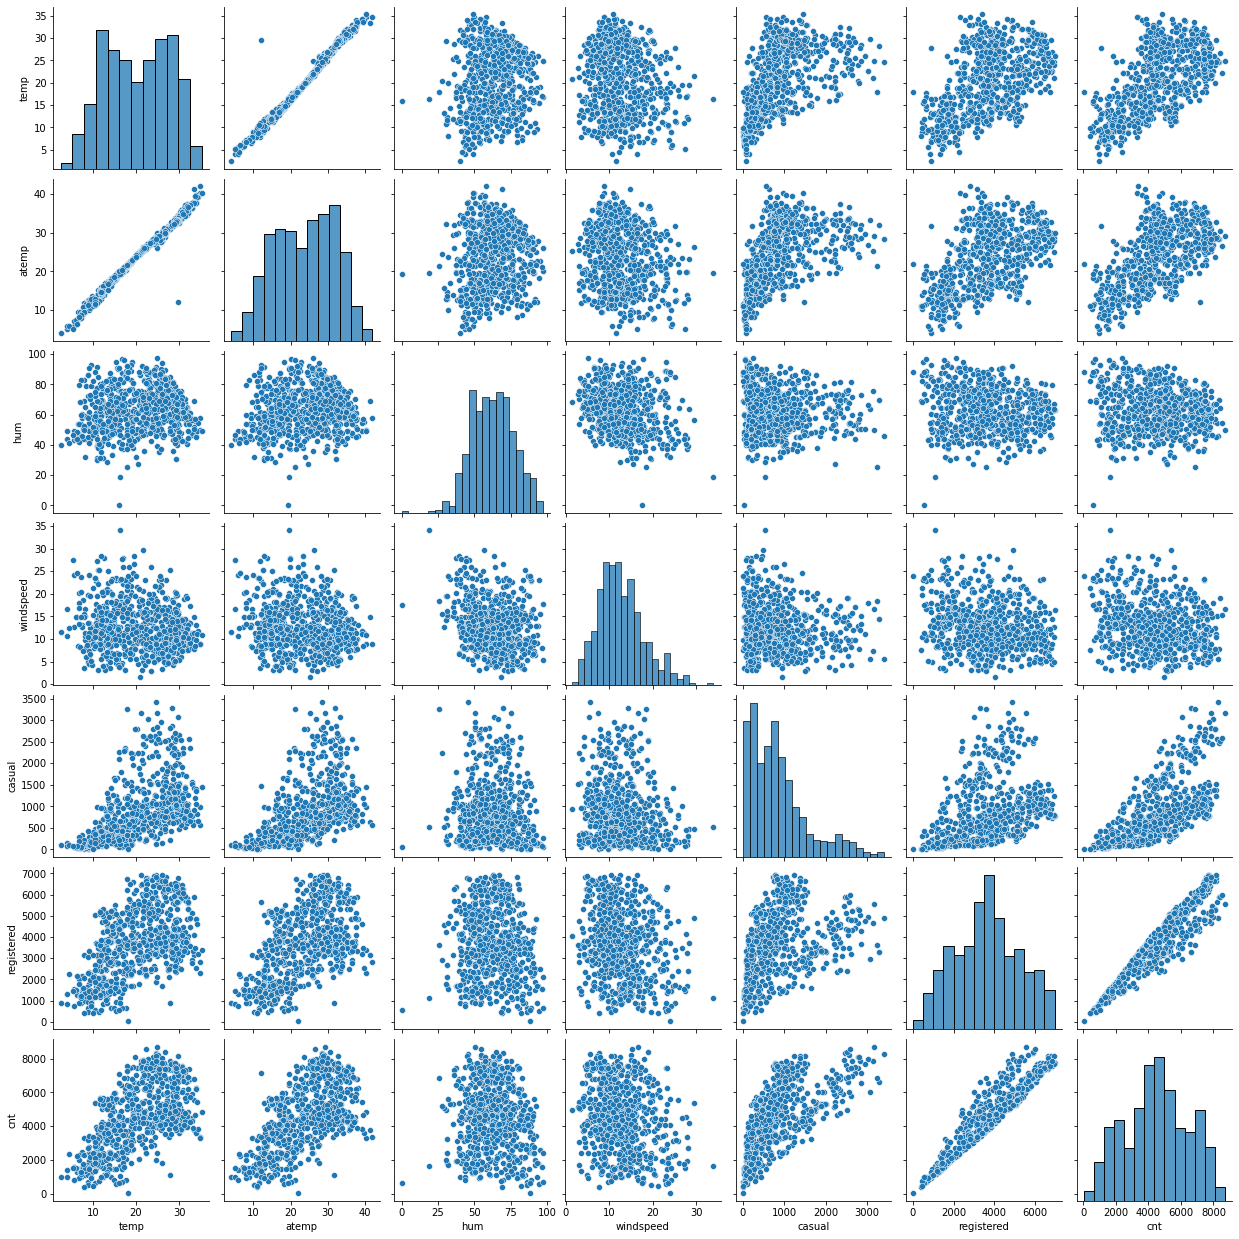

In [10]:
sns.pairplot(rect_data)

As from the heatmap analysis, pairplot holds the same as it reflects the clear visual representaion of correlation.

#### NUMERICAL VS CATEGORICAL

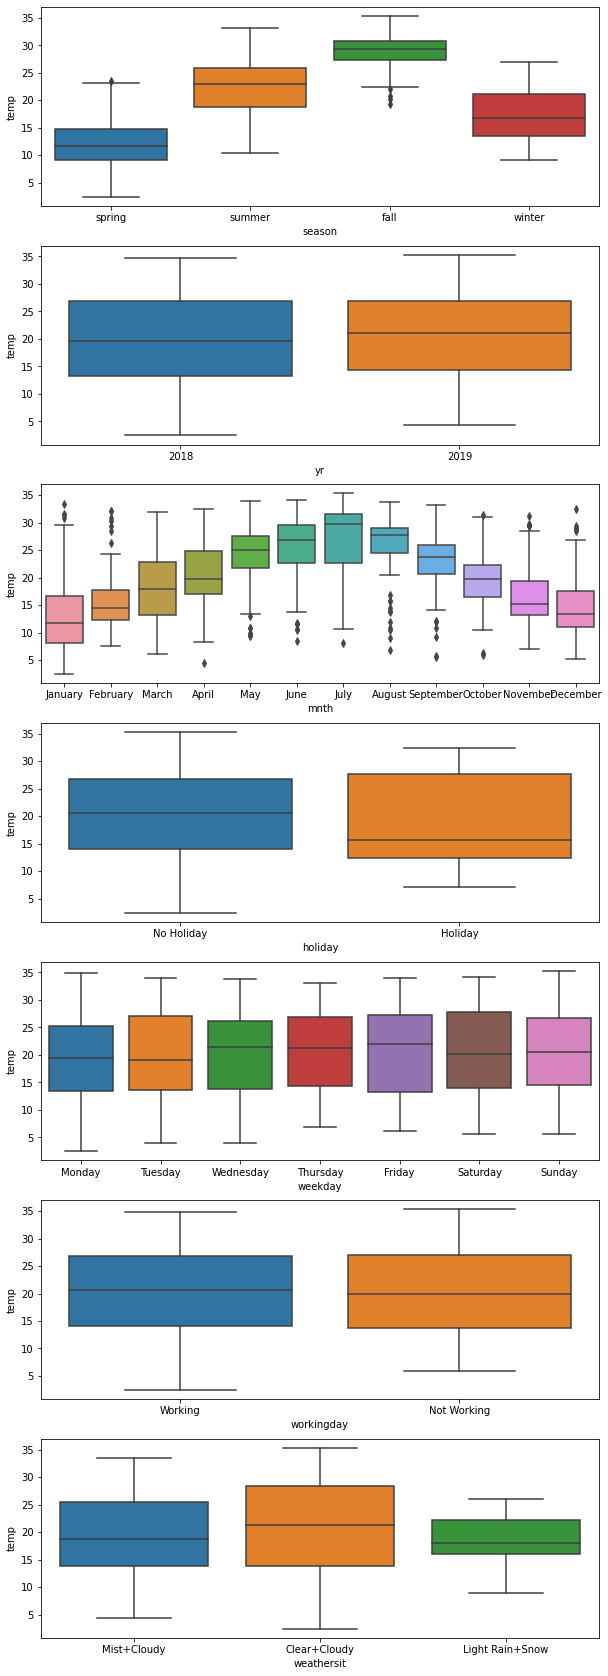

In [11]:
# temp vs all categorical features
boxplots_for_numeric_and_object_features(rect_data, "temp")

- 1. **temp** with **season** and **mnth** will be **correlated**.

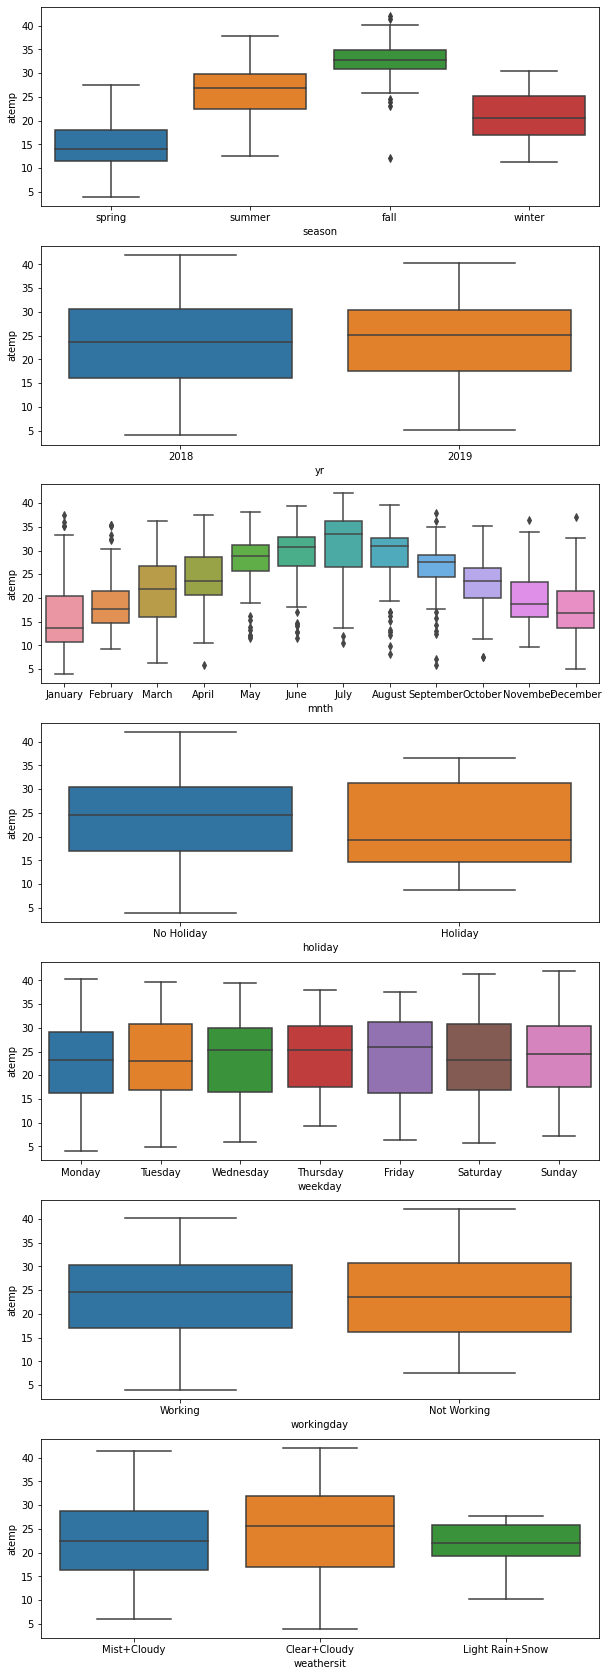

In [12]:
boxplots_for_numeric_and_object_features(rect_data, "atemp")

- 1. **atemp** with **season** and **mnth** will be **correlated**.

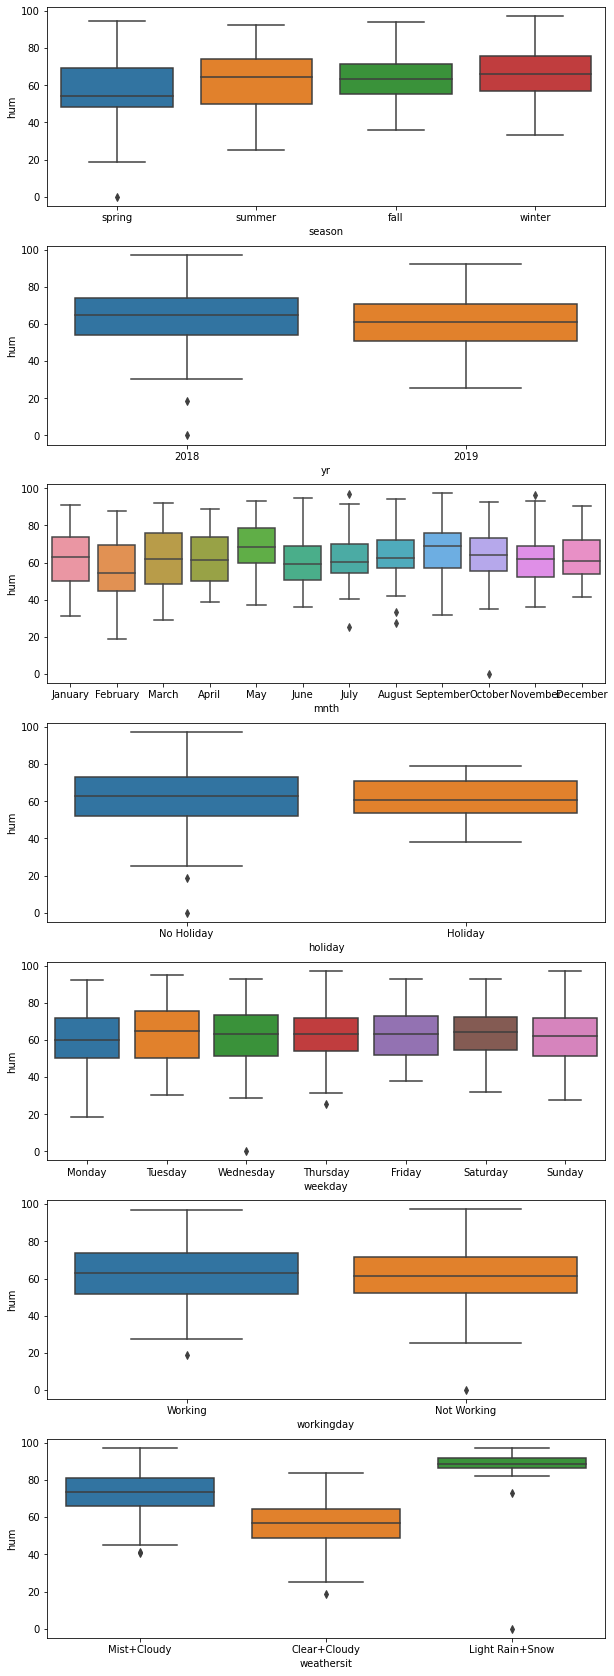

In [13]:
# hum vs all categorical features
boxplots_for_numeric_and_object_features(rect_data, "hum")

- 1. **hum** has **no effect** on any of the features.

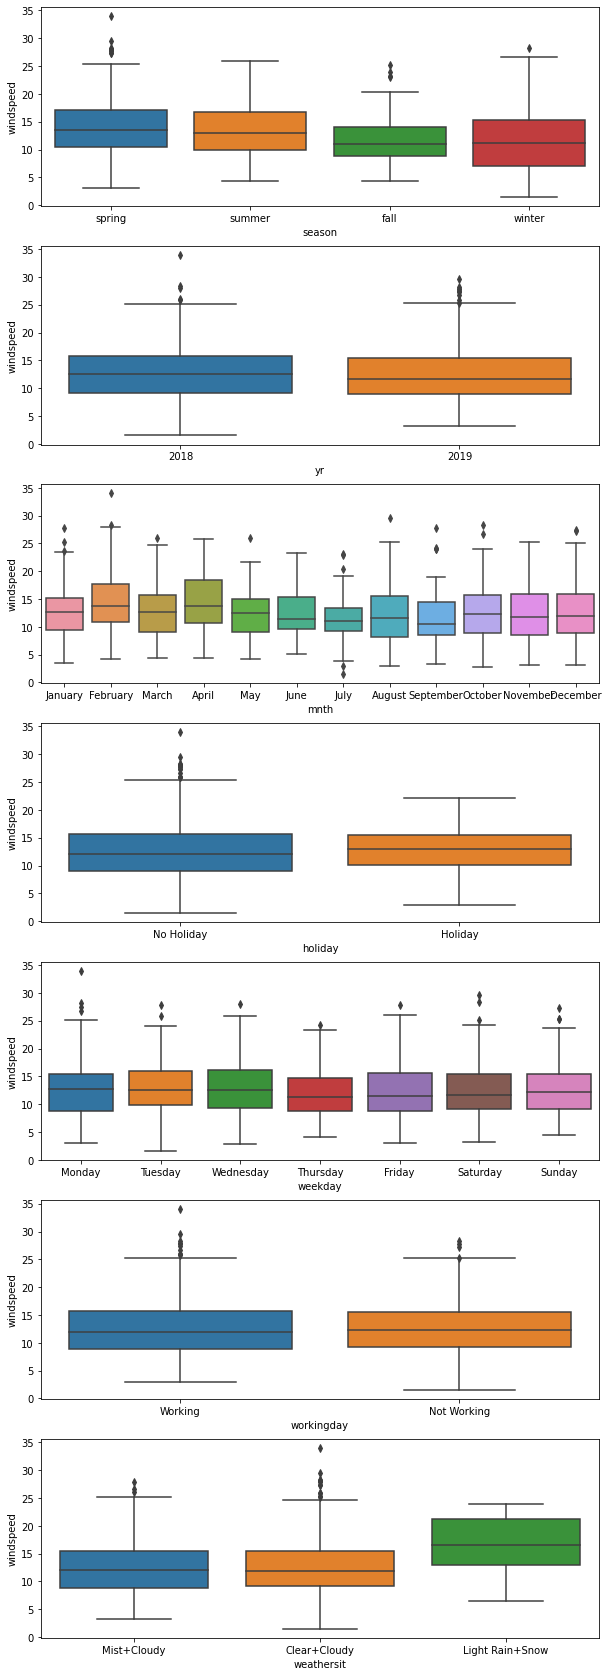

In [14]:
# windspeed vs all categorical features
boxplots_for_numeric_and_object_features(rect_data, "windspeed")

- 1. **windspeed** has **no effect** on any of the features.

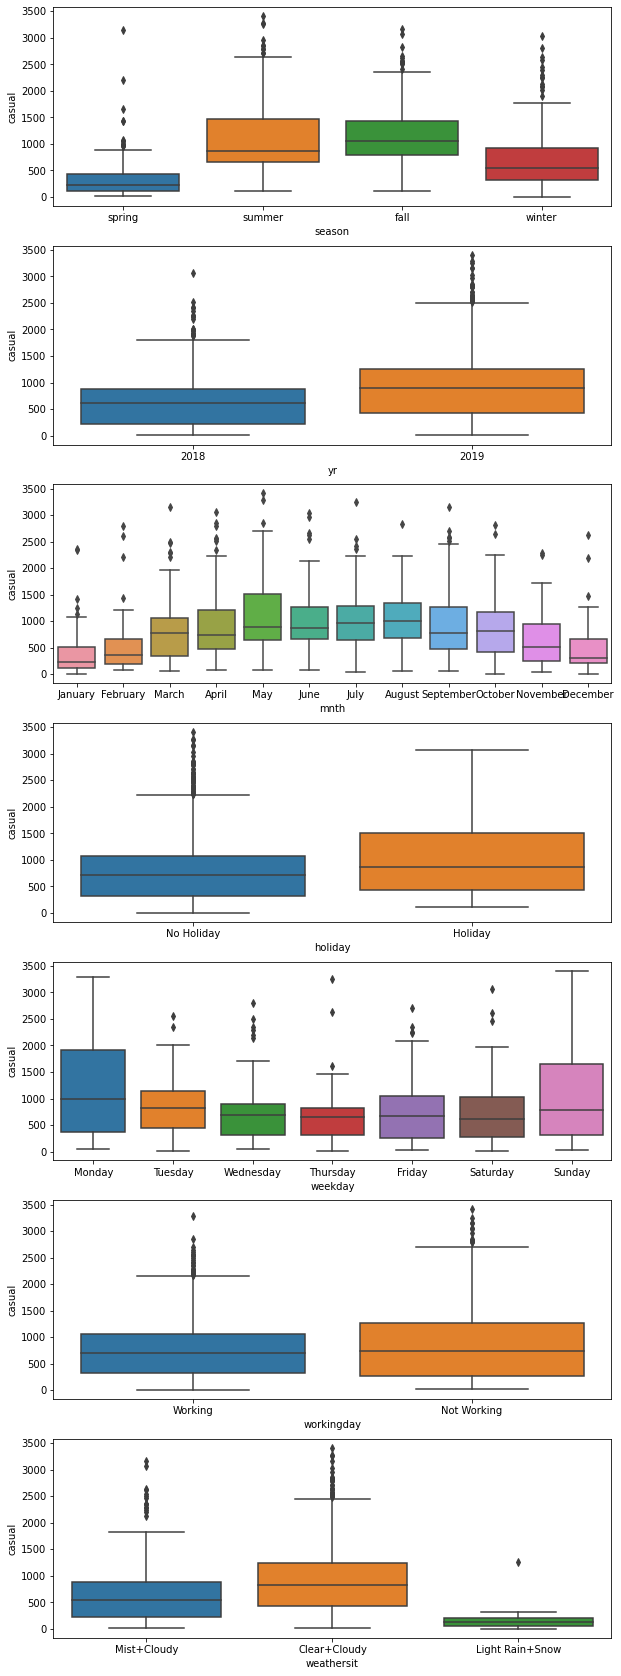

In [15]:
# casual vs all categorical features
boxplots_for_numeric_and_object_features(rect_data, "casual")

- 1. Most **users** rent a bike during **fall season** and when the **weather is clear or cloudy**.

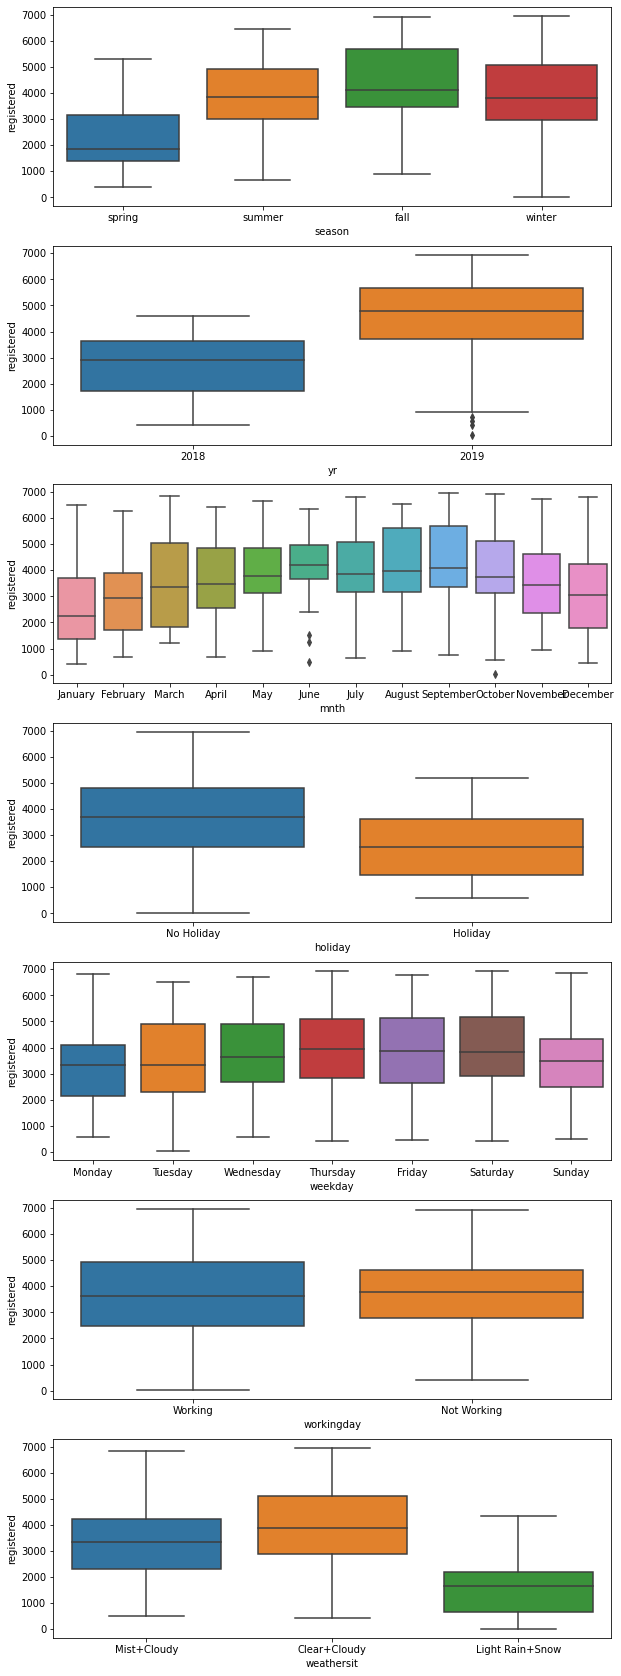

In [16]:
# registered vs all categorical features
boxplots_for_numeric_and_object_features(rect_data, "registered")

- 1. Most **users** rent a bike during **fall season** and when the **weather is clear or cloudy**.

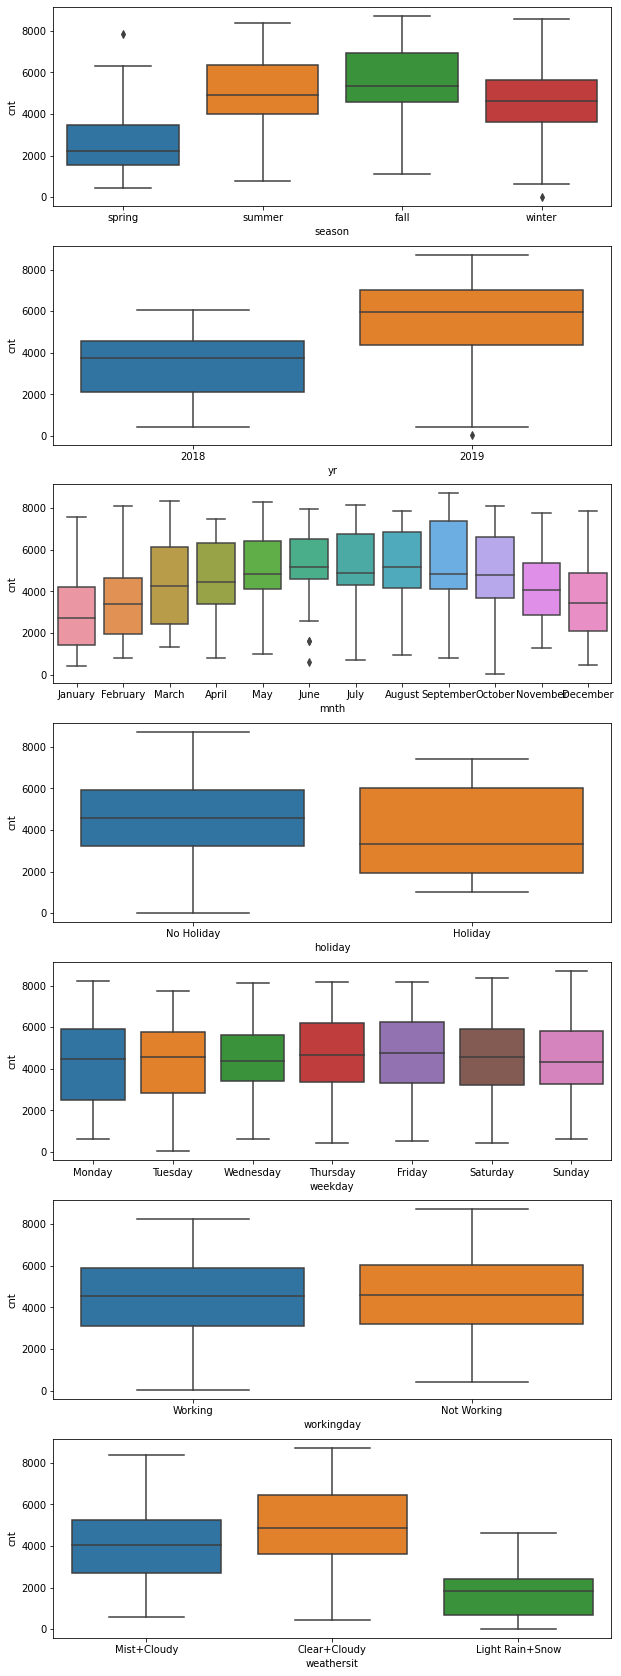

In [17]:
# cnt vs all categorical features
boxplots_for_numeric_and_object_features(rect_data, "cnt")

- 1. Most **users** rent a bike during **fall season** and when the **weather is clear or cloudy**.

### Multivariate Analysis

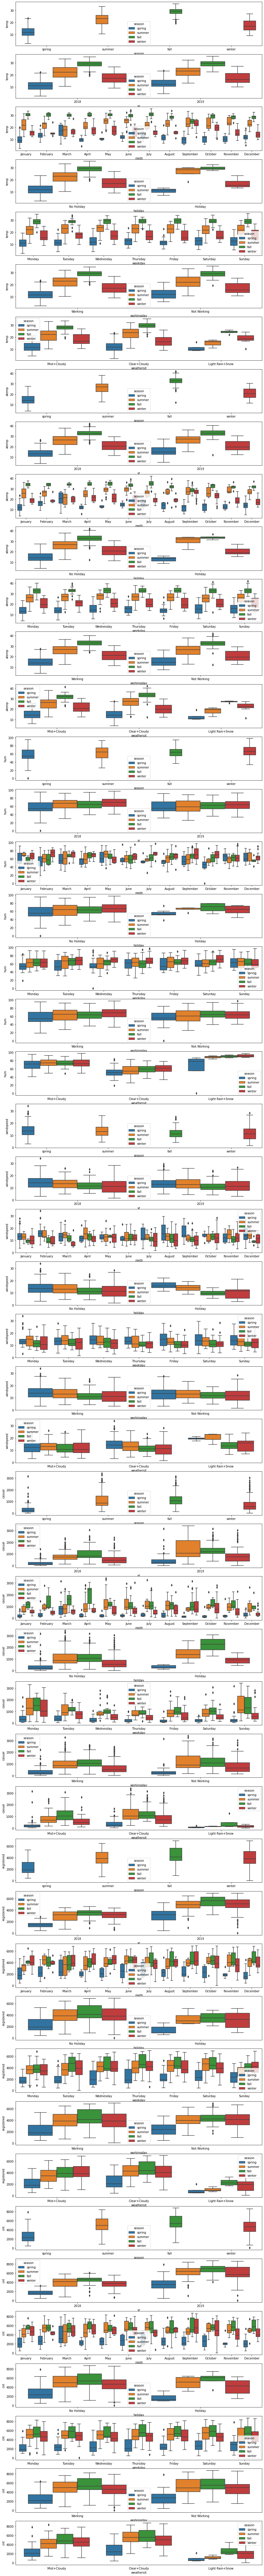

In [18]:
# season with all other numeric and categorical features combination
boxplots_for_numeric_and_object_features(rect_data, hue="season", figsize=(15, 160))

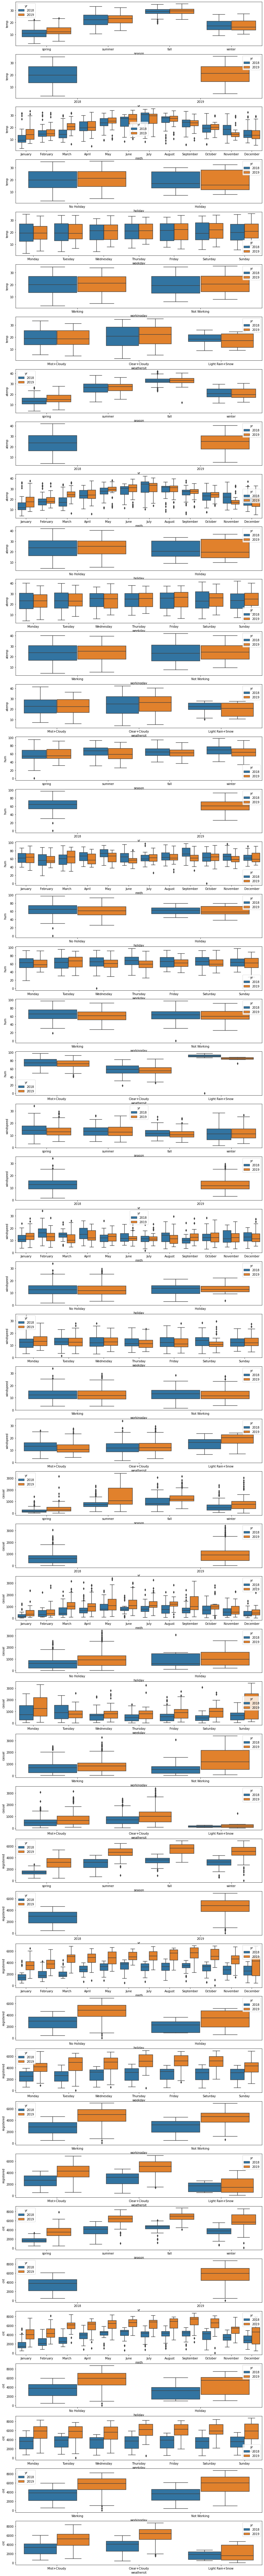

In [19]:
# yr with all other numeric and categorical features combination
boxplots_for_numeric_and_object_features(rect_data, hue="yr", figsize=(15, 160))

By looking at the multivariate plots it is clear that all the above analysis holds true even with multivariate analysis.

## HYPOTHESIS TESTS & REGRESSION

After careful consideration, let's drop some of the columns from the data set which might be irrelevant for linear regression model because of multicollinearity and no use case.

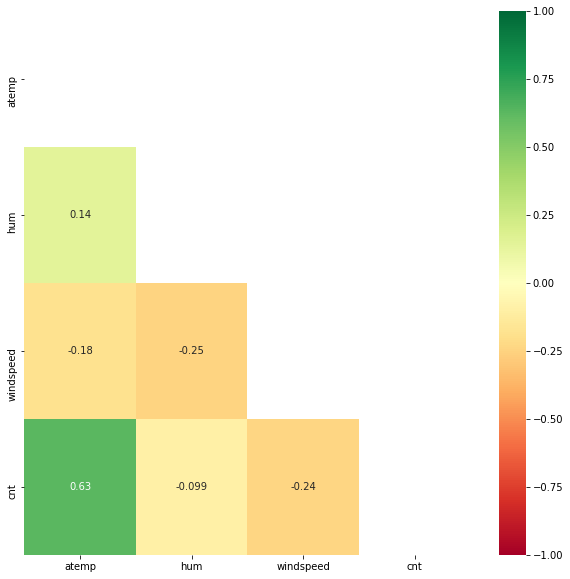

In [8]:
# Making a copy of the rectified data
model_data = rect_data.copy()

# Dropping columns
model_data = model_data.drop(columns=["dteday","mnth","temp","registered","casual","weekday"])

# Heatmap to check multicollinearity after removal of features.
create_heatmap(model_data)

**No linear correlation** is **found** except **atemp** with the target variable **cnt**.

In [9]:
# creating train test split on the model data with 80% split
X_train, X_test, y_train, y_test = prepare_data_for_modeling(model_data, minmaxscaling=True)

# shape of each data we get after splitting
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(584, 11) (146, 11) (584,) (146,)


            feature        VIF
0             atemp  16.549193
1               hum  30.014071
2         windspeed   5.773723
3            spring   4.407435
4            summer   2.355757
5            winter   3.052483
6              2019   2.087085
7        No Holiday  27.913312
8           Working   3.804464
9   Light Rain+Snow   1.261221
10      Mist+Cloudy   2.305274

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     253.6
Date:                Sun, 27 Jun 2021   Prob (F-statistic):          1.01e-211
Time:                        07:41:04   Log-Likelihood:                 557.49
No. Observations:                 584   AIC:                            -1091.
Df Residuals:                     572   BIC:                            -1

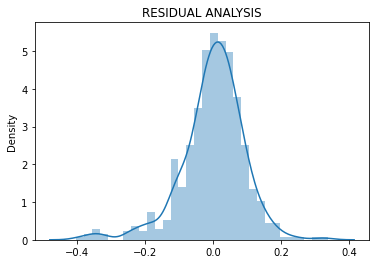

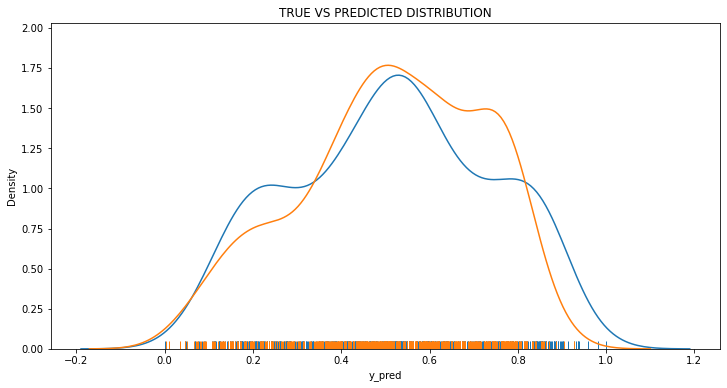

In [10]:
# creating a VIF table to check for variables with multicollinearity 
print(create_VIF_table(X_train))
print()

# using stats model's Oridnary Least squares for model fitting and hypothesis testing
X_train = sm.add_constant(X_train)
lm = create_OLS_model(X_train, y_train, True, True)
print(lm.summary())
print()

# prediction on train data after fitting to check how well model performs after training on the same dataset
y_train_pred = lm.predict(X_train)

# creating evaluation table for true and predicted values
train_eval = model_evaluation(y_train, y_train_pred)

# printing evaluation matrics table
print(train_eval[0])

# comparison histogram for true and predicted values as it gives the visual information of the distribution of true vs predicted
histogram_comparison_for_true_and_predicted_values(train_eval[1]["y_true"], train_eval[1]["y_pred"])

As per VIF **atemp, hum & No Holiday** are found with **high variance** hence **multicollinearity is present**, let's **drop** them **one by one** to get the effect on the result.

In [11]:
X_train.drop(columns=["const"], inplace=True, errors="ignore")
X_train.drop(columns=["hum"], inplace=True, errors="ignore")
X_train.drop(columns=["No Holiday"], inplace=True, errors="ignore")

After **2 iteration** we came up to **drop 2 columns** namely **hum** and **No Holiday** as **atemp** now appears in **acceptable range**.

           feature       VIF
0            atemp  4.708810
1        windspeed  5.359828
2           spring  2.307497
3           summer  1.918700
4           winter  1.830525
5             2019  2.070802
6          Working  3.348557
7  Light Rain+Snow  1.075726
8      Mist+Cloudy  1.509159

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     291.6
Date:                Sun, 27 Jun 2021   Prob (F-statistic):          1.35e-207
Time:                        07:41:10   Log-Likelihood:                 541.94
No. Observations:                 584   AIC:                            -1064.
Df Residuals:                     574   BIC:                            -1020.
Df Model:                           9                                        

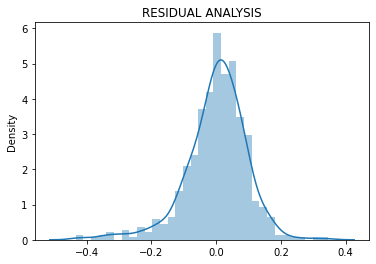

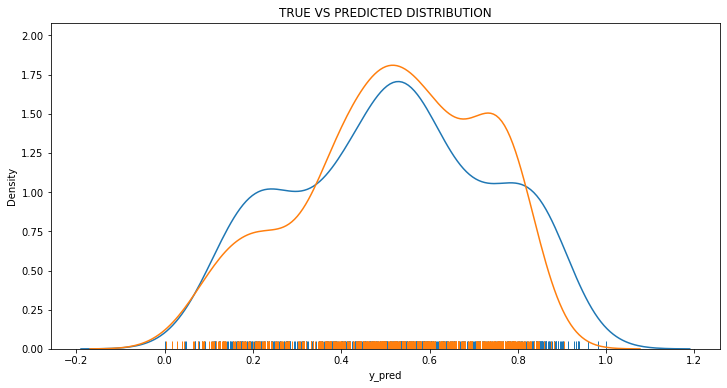

In [12]:
# creating a VIF table to check for variables with multicollinearity 
print(create_VIF_table(X_train))
print()

# using stats model's Oridnary Least squares for model fitting, hypothesis testing and residual analysis
X_train = sm.add_constant(X_train)
lm = create_OLS_model(X_train, y_train, predict=True, res_analysis=True)
print(lm.summary())
print()

# prediction on train data after fitting to check how well model performs after training on the same dataset
y_train_pred = lm.predict(X_train)

# creating evaluation table for true and predicted values
train_eval = model_evaluation(y_train, y_train_pred)

# printing evaluation matrics table
print(train_eval[0])

# comparison histogram for true and predicted values as it gives the visual information of the distribution of true vs predicted
histogram_comparison_for_true_and_predicted_values(train_eval[1]["y_true"], train_eval[1]["y_pred"])

- 1. **All the features** are within **acceptabel range of VIF** hence **no multicollinearity** present in the dataset.
- 2. Every feature has **p-value within 0.05**, hence each **variable is satistically significant**.
- 3. **Ajusted R square** is **above 80% (81.8%)** which means **~82%** of the **data is explained** by this linear regression model.
- 4. According to **residual analysis**, **error terms** have a **mean of 0**, it is **normally distributed** and all the terms are **indipendent of each other**.

## PREDICTIONS

        Scores
MSE   0.010269
RMSE  0.101334
MAE   0.077262
R2    0.764756


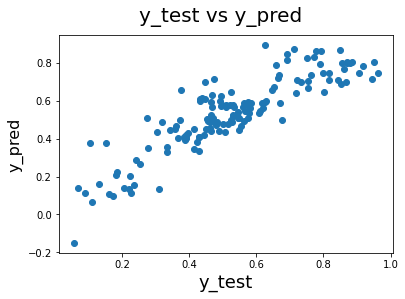

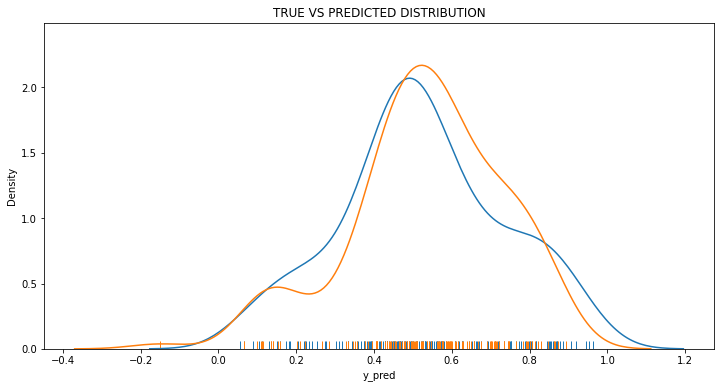

In [13]:
X_test = sm.add_constant(X_test)
X_test = X_test[[x for x in X_train.columns]]

y_test_pred = lm.predict(X_test)

plot_predictions(y_test, y_test_pred)

test_eval = model_evaluation(y_test, lm.predict(X_test))
print(test_eval[0])
histogram_comparison_for_true_and_predicted_values(test_eval[1]["y_true"], test_eval[1]["y_pred"])

- 1. According to **residual analysis**, **error terms** have a **mean of 0**, it is **normally distributed** and all the terms are **indipendent of each other**.
- 2. **True** and **Predicted** values have almost **same distribution curve**.
- 3. The **Q-Q plot** has points that follow a **strongly linear pattern**, suggesting that the data are distributed as a **standard normal distribution**.

### MODEL COMPARISON WITH AND WITHOUT YEAR FEATURE

In [15]:
# Making a copy of the rectified data
model_data = rect_data.copy()

# Dropping columns
model_data = model_data.drop(columns=["dteday","mnth","temp","registered","casual","weekday"])

In [16]:
# creating train test split on the model data with 80% split
X_train, X_test, y_train, y_test = prepare_data_for_modeling(model_data.drop(columns=["yr"]), minmaxscaling=True)

# using stats model's Oridnary Least squares for model fitting and hypothesis testing
X_train = sm.add_constant(X_train)
lm = create_OLS_model(X_train, y_train)

# prediction on train data after fitting to check how well model performs after training on the same dataset
y_train_pred = lm.predict(X_train)

In [17]:
# creating train test split on the model data with 80% split
X_train_yr, X_test_yr, y_train_yr, y_test_yr = prepare_data_for_modeling(model_data, minmaxscaling=True)

# using stats model's Oridnary Least squares for model fitting and hypothesis testing
X_train_yr = sm.add_constant(X_train_yr)
lm_yr = create_OLS_model(X_train_yr, y_train_yr)

# prediction on train data after fitting to check how well model performs after training on the same dataset
y_train_pred_yr = lm_yr.predict(X_train_yr)

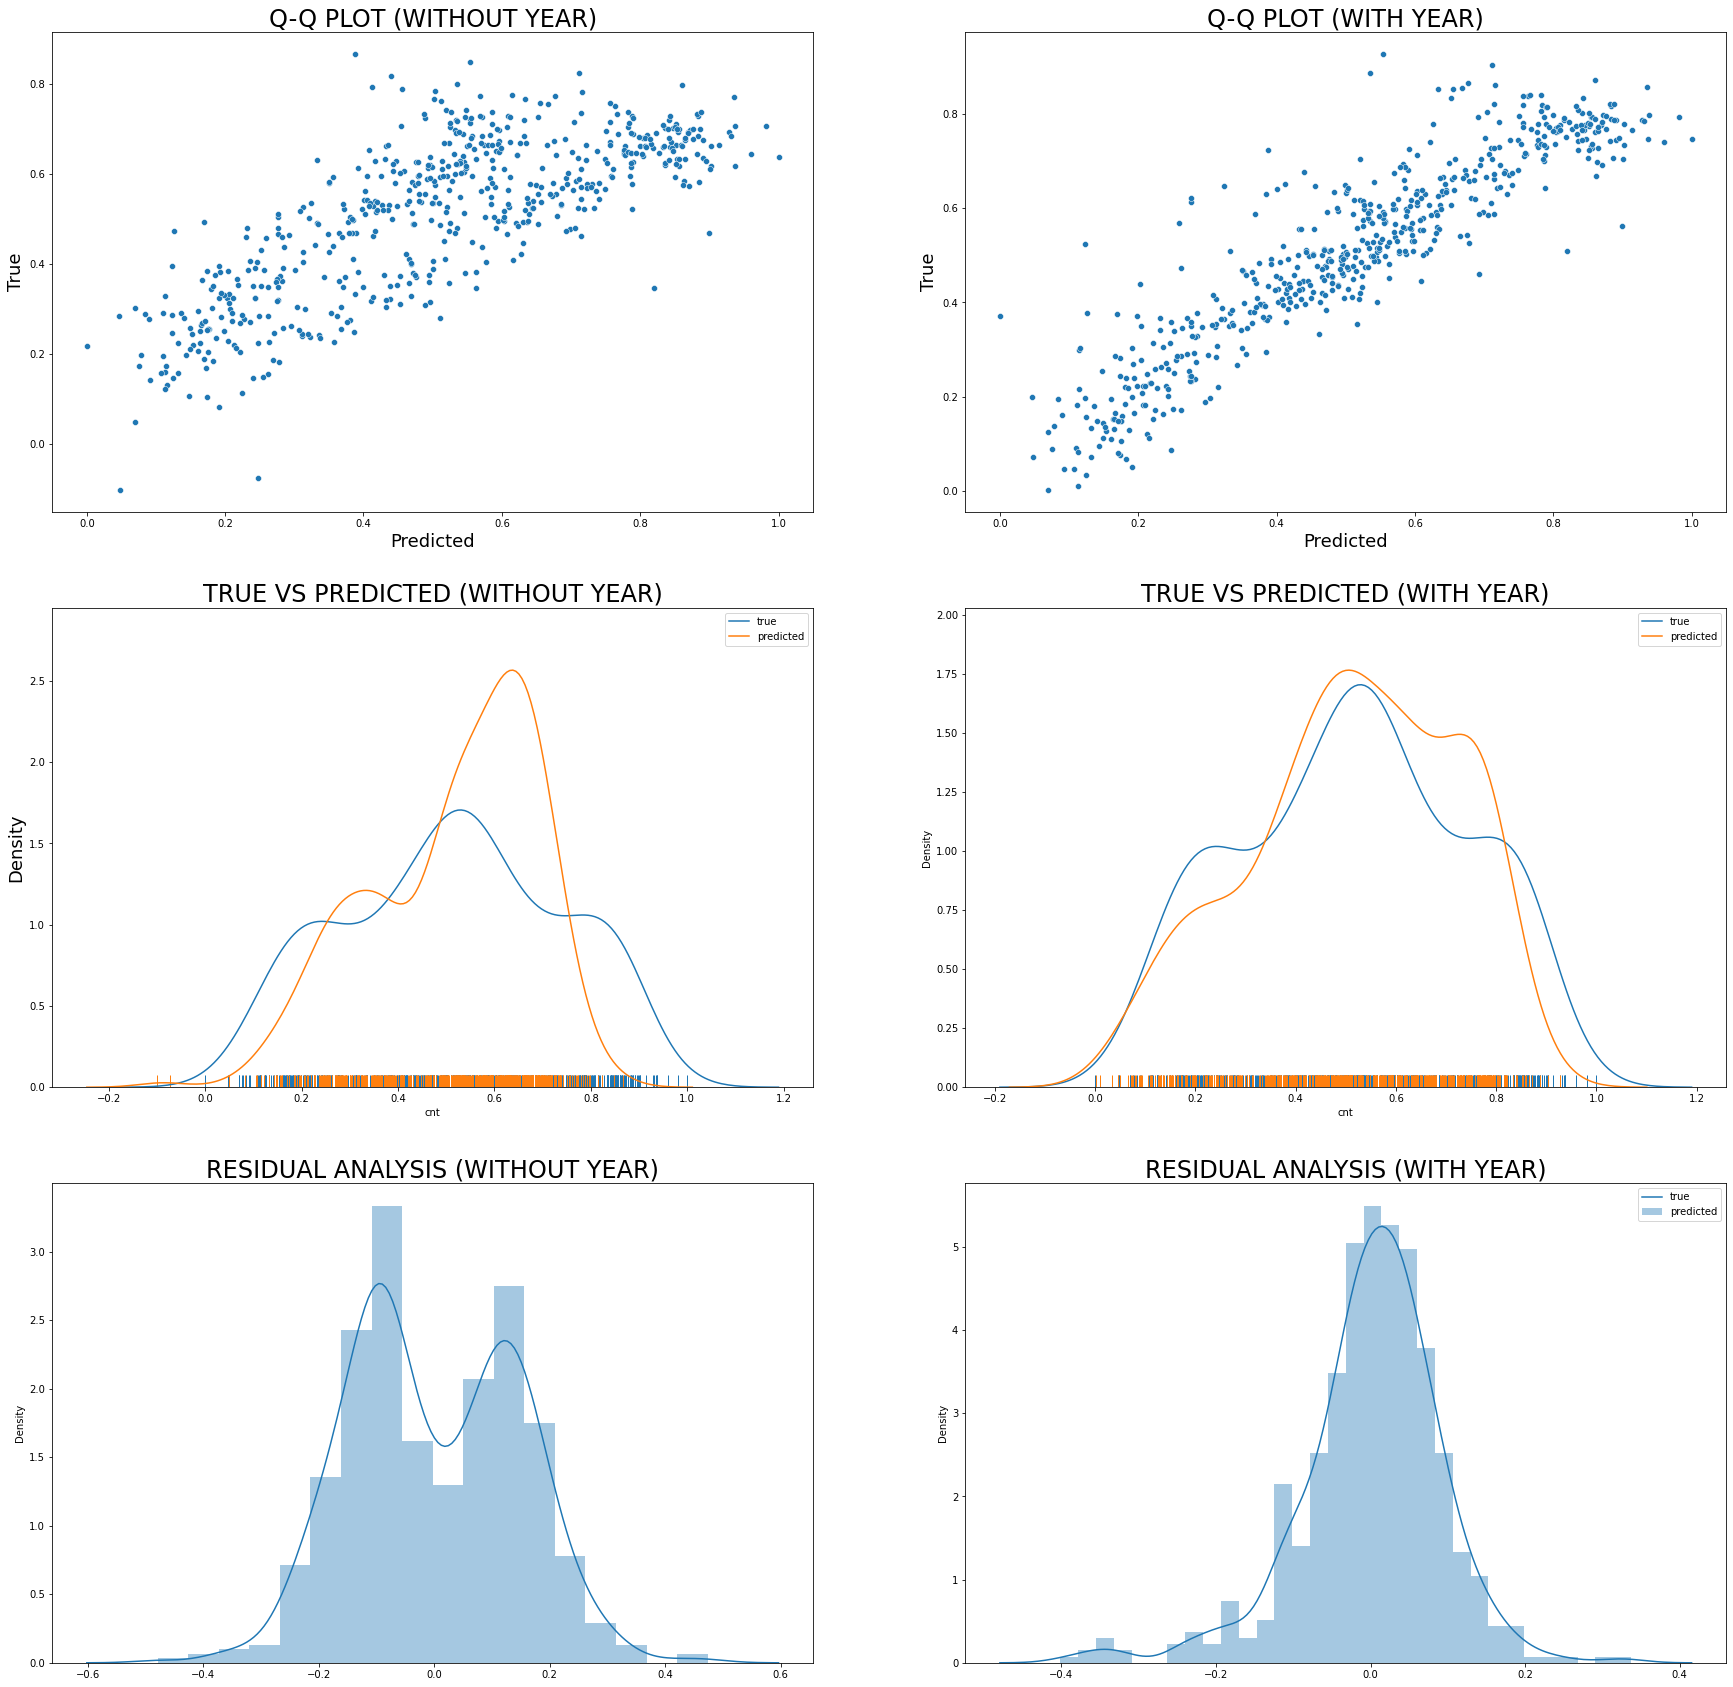

In [19]:
create_plots_for_comparison(y_train, y_train_pred, y_train_yr, y_train_pred_yr)